In [2]:
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import os
import json
from tqdm import tqdm

# Download necessary resources from NLTK
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dcolo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
def preprocess_text(text):
    # Remove punctuation and special characters
    # print(text)
    text = re.sub(r'[^\w\s]', '', text)
    
    # Convert to lowercase
    text = text.lower()
    
    # Tokenize the text into words
    tokens = nltk.word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Join the tokens back into a single string
    processed_text = ' '.join(tokens)
    
    return processed_text

In [4]:
#  Dump all artilces into one file as title category and text
# os.chdir("D:/nlp/")
# article_dump_folder = 'cleaned_articles'

# # List all JSON files in the folder
# json_files = [f for f in os.listdir(article_dump_folder) if f.endswith('.json')]

# # Extract text, title, and categories from each JSON file
# articles = []
# for json_file in json_files:
#     with open(os.path.join(article_dump_folder, json_file), 'r') as file:
#         article_data = json.load(file)
        
#         title = article_data['title']
#         text = article_data['text']
#         categories = article_data['categories']
        
#         articles.append({'title': title, 'text': text, 'categories': categories})

In [5]:
# with open("articles_dump.json", "w", encoding="utf8") as f:
#     json.dump(articles, f, indent=2, ensure_ascii=False)

In [6]:
os.chdir("D:/nlp/")
with open("articles_dump.json", "r", encoding="utf8") as f:
    articles = json.load(f)

In [7]:
# Preprocess the text
# preprocessed_texts = [preprocess_text(article['text'][0]) for article in tqdm(articles)]

In [8]:
# Create a TF-IDF vectorizer
# vectorizer = TfidfVectorizer()
# tfidf_matrix = vectorizer.fit_transform(preprocessed_texts)



In [9]:
# Get the feature names (words) from the vectorizer

# feature_names = vectorizer.get_feature_names_out()



In [10]:
# # Print the preprocessed text, title, and the corresponding TF-IDF matrix
# for article, preprocessed_text, tfidf_vector in (zip(articles, preprocessed_texts, tfidf_matrix)):
#     print('Title:', article['title'])
#     print('Preprocessed Text:', preprocessed_text)
#     print('TF-IDF Vector:', tfidf_vector.toarray())
#     print('------------------------------------')

In [11]:
def calculate_jaccard_similarity(category1_articles, category2_articles):
    category1_set = set(category1_articles)
    category2_set = set(category2_articles)
    
    intersection = len(category1_set.intersection(category2_set))
    union = len(category1_set) + len(category2_set) - intersection
    
    jaccard_similarity = intersection / union
    return jaccard_similarity


In [12]:


# List of categories and their corresponding articles
categories = []
category_articles = {}
for article in tqdm(articles):
    for category in article['categories']:
        categories.extend(category.split(":")[1])






100%|██████████| 538077/538077 [00:03<00:00, 176080.49it/s]


In [13]:
for article in tqdm(articles):
    for category in (article['categories']):
        if category.split(":")[1] not in category_articles:
            category_articles[category.split(":")[1]] = []
        category_articles[category.split(":")[1]].append(article["title"])

100%|██████████| 538077/538077 [00:05<00:00, 89840.36it/s] 


In [14]:
category_articles.__len__()

612946

In [15]:
category_articles_filtered = {
    category: articles for category, articles in category_articles.items() if len(articles) >= 5}
category_articles_filtered.__len__()

categories = list(category_articles_filtered.keys())


In [16]:
categories.__len__()

144119

In [17]:
import Levenshtein

def calculate_levenshtein_distance(category1, category2):
    distance = Levenshtein.distance(category1, category2)
    return distance




In [18]:
# Compute category similarity incrementally using random projection and sparse matrix
import numpy as np
num_categories = len(categories)

# Random projection for dimensionality reduction
similarity_matrix = np.zeros((num_categories, num_categories))

for i in tqdm(range(num_categories), total=num_categories):
    for j in range(i + 1, num_categories):  # Iterate over the upper triangular part
        category1 = categories[i]
        category2 = categories[j]
        
        category1_articles = category_articles_filtered[category1]
        category2_articles = category_articles_filtered[category2]

        levenshtein_similarity = calculate_levenshtein_distance(category1_articles, category2_articles)

        similarity_matrix[i, j] = levenshtein_similarity
        similarity_matrix[j, i] = levenshtein_similarity

# Fill the diagonal with 1.0
np.fill_diagonal(similarity_matrix, 1.0)

# Print the similarity matrix
print(similarity_matrix)

MemoryError: Unable to allocate 155. GiB for an array with shape (144119, 144119) and data type float64

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram

top_count=10
sorted_indices = similarity_matrix.mean(axis=1).argsort()
top_categories = [categories[idx] for idx in sorted_indices[:top_count]]

# Subset the similarity matrix and categories for the top ten categories
top_similarity_matrix = similarity_matrix[np.ix_(sorted_indices[:top_count], sorted_indices[:top_count])]
top_categories = [categories[idx] for idx in sorted_indices[:top_count]]
Z = linkage(top_similarity_matrix[1:top_count], method='average', metric='euclidean')



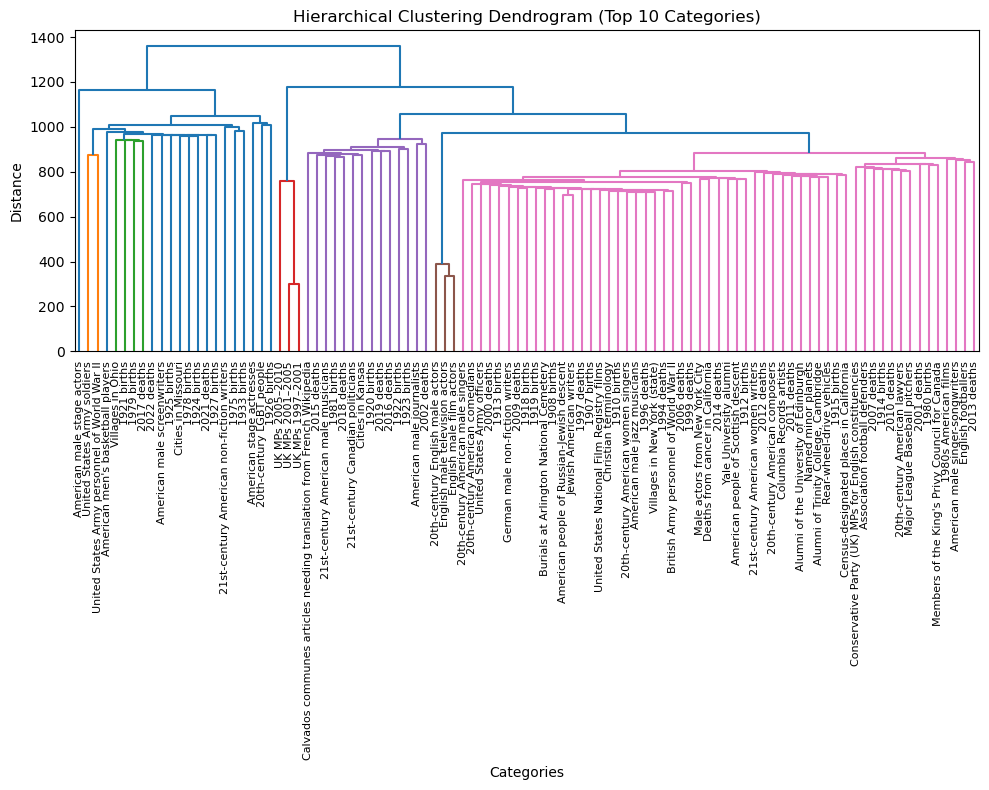

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 8))
dendrogram(Z, labels=top_categories[1:top_count], orientation='top')

plt.title('Hierarchical Clustering Dendrogram (Top 10 Categories)', fontsize=12)
plt.xlabel('Categories', fontsize=10)
plt.ylabel('Distance', fontsize=10)
plt.xticks(rotation=90, fontsize=8)

# Show the plot
plt.tight_layout()
plt.show()

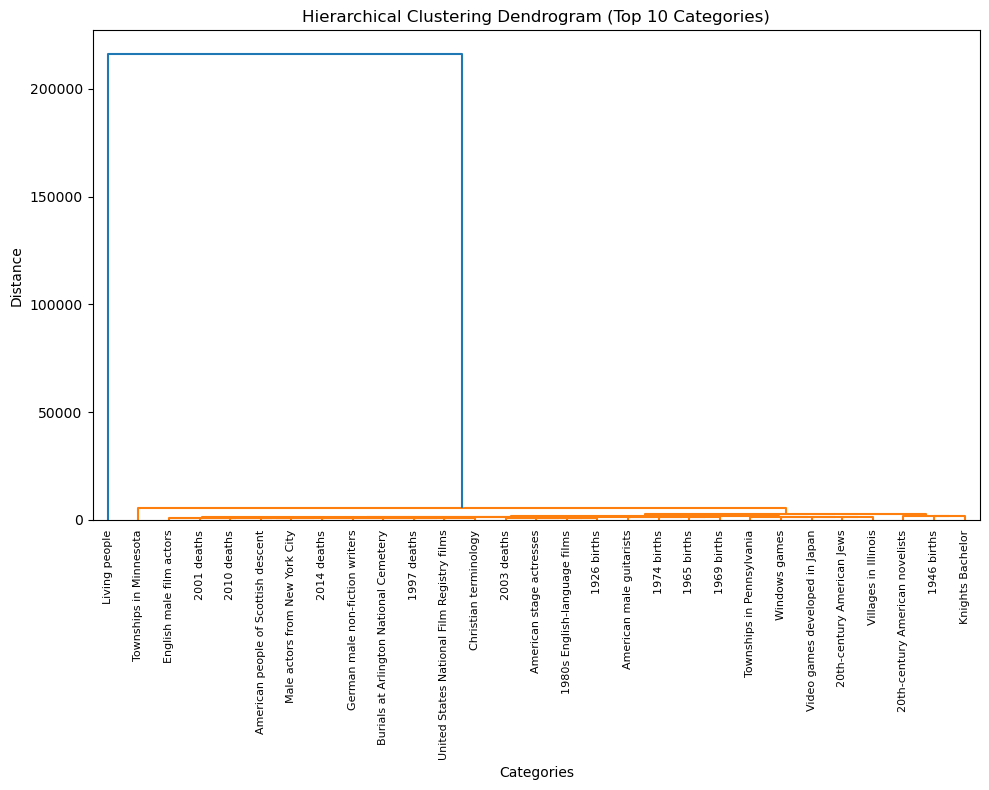

In [ ]:
import random
random_count=30
random_indices = random.sample(range(0, categories.__len__()), random_count)
random_categories = [categories[idx] for idx in random_indices[:random_count]]

# Subset the similarity matrix and categories for the top ten categories
random_similarity_matrix = similarity_matrix[np.ix_(random_indices[:random_count], random_indices[:random_count])]
top_categories = [categories[idx] for idx in random_indices[:random_count]]
Z = linkage(random_similarity_matrix[1:random_count], method='average', metric='euclidean')
fig, ax = plt.subplots(figsize=(10, 8))
dendrogram(Z, labels=random_categories[1:random_count], orientation='top')

plt.title('Hierarchical Clustering Dendrogram (Top 10 Categories)', fontsize=12)
plt.xlabel('Categories', fontsize=10)
plt.ylabel('Distance', fontsize=10)
plt.xticks(rotation=90, fontsize=8)

# Show the plot
plt.tight_layout()
plt.show()